# 4. Model Evaluation
In machine learning, model validation is referred to as the process where a trained model is evaluated with a testing data set. The testing data set is a separate portion of the same data set from which the training set is derived. The main purpose of using the testing data set is to test the generalization ability of a trained model ([Alpaydin 2010](http://scholar.google.com/scholar_lookup?title=Introduction%20to%20machine%20learning&author=E.%20Alpaydin&publication_year=2010)).
 
 In simpler terms, model evaluation tells you what kind of performance you can expect once your run **future** data through the model.
 
 The outline of the model building and evaluation process is given below.
 <img src="../img/4/model_evaluation_process.PNG" width=400>
 
 We will start by training a classification model that uses the [scikit-learn implementation](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html) of the [Random Forest](https://en.wikipedia.org/wiki/Random_forest) algorithm.

## 4.1 Building a classifier model using the Random Forest algorithm

In [22]:
# load necessary Python packages
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score, cross_val_predict, TimeSeriesSplit
from sklearn.metrics import average_precision_score, accuracy_score, confusion_matrix
from sklearn.metrics import precision_recall_curve, precision_score, recall_score
from sklearn.model_selection import StratifiedKFold, train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# data are stored here
data_folder = '../datasets'

# integer for the random seed
THE_ANSWER = 42

In [55]:
# load all data
data = np.load('%s/data.npz' % data_folder)

# extract training data
# (strategies for splitting data into training and test sets are detailed in Section 4.4)
X_train, y_train = data['X_train'], data['y_train']

#Let's have a look at the first datapoint
print("The first datapoint contains the following features:\n")
print(X_train[0], '\n')
print("Each data point is described by %d features." % X_train.shape[1])
print("The number of data points in the training dataset is %d." % X_train.shape[0])

The first datapoint contains the following features:

[ 0.6156176  -0.78584207  0.56566955  0.60753437 -0.17992427 -0.32535287
 -0.32719857 -0.32719857 -0.15201037  0.18929607  0.21877548         nan
 -1.564559           nan  1.87409565  0.3909332  -1.64262716 -0.33748312
  1.64262716         nan         nan  0.90230299         nan         nan
  1.37062409 -0.00604467 -0.01317495 -0.76401196  0.93544524 -0.04058151
 -0.17166864 -0.02962516 -0.26744559] 

Each data point is described by 33 features.
The number of data points in the training dataset is 65579.


In [51]:
# let's take a look at the class labels stored in the y_train array
print(y_train)
print('The class == 1 objects make %0.f%% of the training set.' % (100*y_train.sum()/y_train.size))

[0. 1. 1. ... 0. 0. 0.]
The class == 1 objects make 34% of the training set.


**only 34% of objects are of class 1 --> the data set is imbalanced**

Let's start with training a classifier on the training set and then testing its performance on the test dataset.

In [5]:
# instantiate the RandomForestClassifier
model = RandomForestClassifier()

# print out the default values of model hyper-parameters (will talk about hyper-parameters later)
model

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [6]:
# set the number of trees to 500, and the random seed to THE_ANSWER for reproducibility
model.set_params(n_estimators=500, random_state=THE_ANSWER)
#model = RandomForestClassifier(n_estimators=500, random_state=THE_ANSWER) # another way of doing it

# check that the model changed
model

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=None,
            oob_score=False, random_state=42, verbose=0, warm_start=False)

In [7]:
# some values in the training set are NaN (i.e., are missing).
# The Random Forest classifier does not like that, so we set NaN values to 10000.
X_train_fixed = X_train.copy()
X_train_fixed[np.isnan(X_train_fixed)] = 10000

In [8]:
# fit the model using training data
model.fit(X_train_fixed, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=None,
            oob_score=False, random_state=42, verbose=0, warm_start=False)

## 4.2 Evaluating a model using classification metrics

Now that we have fit a model, we need to evaluate its performance on a test set. Strategies for splitting data into training and test sets are detailed in [Section 4.4](#4_4).

In [62]:
# first, extract test data
X_test, y_test = data['X_test'], data['y_test']

# if there are NaNs in the test set, set them to 10000.
X_test_fixed = X_test.copy()
X_test_fixed[np.isnan(X_test)] = 10000

# sanity check: only 35% of objects are of class 1 --> the test set is also imbalanced
#print('The class == 1 objects make %0.f%% of the test set.\n' % (100*y_test.sum()/y_test.size))

# now push the test set through the model to get the predicted classes
y_pred = model.predict(X_test_fixed)

print('True class:     ', y_test[0:20])
print('Predicted class:', y_pred[0:20])

True class:      [1. 0. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 1. 1. 0. 1. 0. 0. 0. 0.]
Predicted class: [0. 0. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0.]


### 4.2.1 Confusion matrix
When performing classification predictions, there are four types of outcomes that could occur.

#### True positives
are when you predict an observation belongs to a class and it actually does belong to that class.
#### True negatives
are when you predict an observation does not belong to a class and it actually does not belong to that class.
#### False positives
occur when you predict an observation belongs to a class when in reality it does not.
#### False negatives
occur when you predict an observation does not belong to a class when in fact it does.

These four outcomes are often plotted on a confusion matrix. Let's plot the confusion matrix for the predictions we have obtained above on the test set.

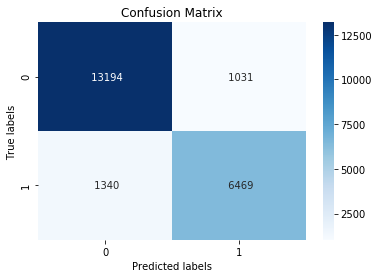

In [57]:
labels = [1, 0]
cm = confusion_matrix(y_test, y_pred)

ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax, fmt=' ', cmap="Blues"); #annot=True to annotate cells

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
#ax.xaxis.set_ticklabels([1, 0]); ax.yaxis.set_ticklabels([1,0])

In [58]:
TP = cm[1][1]
TN = cm[0][0]
FP = cm[0][1]
FN = cm[1][0]

print("True  Positives = %i" % TP)
print("True  Negatives = %i" % TN)
print("False Positives = %i" % FP)
print("False Negatives = %i" % FN)

True  Positives = 6469
True  Negatives = 13194
False Positives = 1031
False Negatives = 1340


Having these numbers, we can now calculate some classification metrics, such as accuracy, precision, and recall.

### 4.2.2 Accuracy

Accuracy is defined as the percentage of correct predictions for the test data.

$$accuracy = \frac{{\rm number\, of\, correct\, predictions}}{{\rm number\, of\, all\, predictions}}$$

In [63]:
# calculate the accuracy
print('The accuracy is %.3f.' % accuracy_score(y_test, y_pred))

The accuracy is 0.892.


That's a great result, right? Maybe not since we have an imbalanced data set (i.e., class == 1 objects make only 35% of the test set). Here's an extreme example how accuracy can be misleading when the classes are imbalanced:

Imagine a data set where 90% of objects are of class 0. A naive classifier that predicts 0 for all objects will have an accuracy of 90%!

### 4.2.3 Precision and Recall<a name="4_2_3"></a>

In my opinion, what most business people would like to know is the following:
1. What is the detection rate? Did we correctly identify 50%, 80%, or more of all class 1 objects (e.g., instructions that will fail to settle)?
2. What is the false alarm rate? What percentage of those tagged as class 1 are **not** of class 1?

The detection rate is called ["recall"](https://en.wikipedia.org/wiki/Precision_and_recall) in machine learning, and the false alarm rate is related to ["precision"](https://en.wikipedia.org/wiki/Precision_and_recall) (actually, it is 1-precision).

#### Precision
is defined as the fraction of relevant examples (true positives) among all of the examples which were predicted to belong in a certain class.
$$Precision = \frac{true\, positives}{true\, positives+false\, positives}$$

#### Recall
is defined as the fraction of examples which were predicted to belong to a class with respect to all of the examples that truly belong in the class.
$$Recall = \frac{true\, positives}{true\, positives+false\, negatives}$$

![image](../img/4/img7.png)

[Source](https://www.jeremyjordan.me/evaluating-a-machine-learning-model/)

Let's calculate precision and recall using the predictions we have obtained above on the test set.

In [64]:
p = precision_score(y_test, y_pred)
r = recall_score(y_test, y_pred)
print('The precision obtained on the test set is %.0f%% and recall is %.0f%%.' % (p*100, r*100))

The precision obtained on the test set is 86% and recall is 83%.


The above precision and recall indicate that our model is able to detect 83% of all class == 1 objects (e.g., failed settlements), while having a false alarm rate of only 14% (remember that the false alarm rate = 1 - precision).

But what if a detection rate of 86% is not good enough for your use case? What if you willing to accept a higher false alarm rate if that would enable you to identify more of class == 1 objects (i.e., have a higher detection rate)?

This can be achieved by:
1. Calculating classification **scores** (values 0 *to* 1) instead of predicting class **labels** (values 0 *or* 1),
2. Plotting the precision-recall curve, and
3. Selecting all objects that have the classification score higher than some threshold.

Let's start by calculating and explaining classification scores.

In [67]:
# push the test data set through the model to get the classification *scores* (not labels)
# (note that we use the "predict_proba" method and not "predict")
y_scores = model.predict_proba(X_test_fixed)

# the model calculates the score for both classes (0 and 1). Each row sums to 1.
print(y_scores[0:5, :])
print('The y_scores is a 2-dimensional array:', y_scores.shape)

[[0.88866667 0.11133333]
 [0.828      0.172     ]
 [0.85693333 0.14306667]
 [0.88866667 0.11133333]
 [0.80310476 0.19689524]]
The y_scores is a 2-dimensional array: (22034, 2)


Now that we have classification scores, let's plot the (1-precision) vs. recall curve.

Score > 0.557:  78% detection rate at 10% false alarm rate.
Score > 0.487:  84% detection rate at 15% false alarm rate.
Score > 0.451:  87% detection rate at 20% false alarm rate.
Score > 0.000: 100% detection rate at 65% false alarm rate (naive approach).


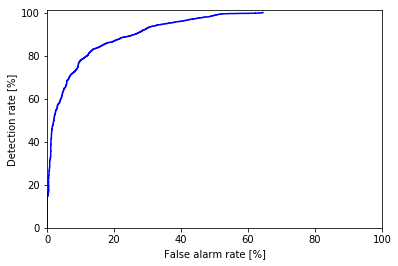

In [68]:
# plot the detection rate vs. false alarm rate
p, r, thresh = precision_recall_curve(y_test, y_scores[:, 1])
thresh = np.append(0, thresh)
print('Score > %.3f:  %.0f%% detection rate at 10%% false alarm rate.' % (thresh[(1-p) > 0.1][-1], 100*r[(1-p) > 0.1][-1]))
print('Score > %.3f:  %.0f%% detection rate at 15%% false alarm rate.' % (thresh[(1-p) > 0.15][-1], 100*r[(1-p) > 0.15][-1]))
print('Score > %.3f:  %.0f%% detection rate at 20%% false alarm rate.' % (thresh[(1-p) > 0.2][-1], 100*r[(1-p) > 0.2][-1]))
print('Score > 0.000: 100%% detection rate at %.0f%% false alarm rate (naive approach).' % (100-100*y_test.sum()/y_test.size))

fig, ax = plt.subplots()
ax.step((1-p)*100, r*100, color='b', where='post', label='late settlements')
ax.set_xlabel('False alarm rate [%]')
ax.set_ylabel('Detection rate [%]')
ax.set_ylim([0.0, 101])
_ = ax.set_xlim([0.0, 100])

</a>Thus, if we select all objects (rows) that have the classification score (y_scores[:, 1]) greater than 0.557, we can expect a sample where 78% of objects will be of class 1 (e.g., will be failed settlements), and only 10% will be of class 0.

Example: Let's say there are 100 objects (rows) that have the classification score greater than 0.577. This mean that 90 objects will truly be of class 1 (false alarm rate is 10% --> precision is 90% --> 100*0.9 = 90). The total number of class 1 objects is 115 ( = 90/0.78 --> because detection rate is 78%), which means the algorithm misses 25 objects (rows) of class 1.

The area under the precision-recall curve (AUPRC) is also a [metric](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.average_precision_score.html). The perfect classifier (model) has a detection rate of 100% and false alarm rate of 0%, and the AUPRC = 1.

What is the AUPRC for the model we trained above? Let's calculate it using the test data set.<a name="precision_recal_sec_end">

In [15]:
# calculate the area under the precision-recall curve for class == 1 objects
# by feeding the true class label (y_test) and the predicted classification scores (y_scores[:, 1])
print('The area under the precision-recall curve is %.3f.' % average_precision_score(y_test, y_scores[:, 1]))

The area under the precision-recall curve is 0.923.


### 4.2.4 Log loss or cross-entropy

The metric of choice for evaluating multi-class classification models. For more details, see [here](http://wiki.fast.ai/index.php/Log_Loss) and [here](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.log_loss.html#sklearn.metrics.log_loss).

## 4.3 Regression metrics

**(Root) Mean Squared Error** is simply defined as the (root of the) average of squared differences between the predicted output and the true output. A smaller value of this metric indicates a better model. The root of MSE is in units of *y*.
$$MSE(y_{true}, y_{pred})=\frac{1}{n_{samples}}\sum{(y_{true} - y_{pred})^2}$$

[${\bf R^2}$ **coefficient**](https://en.wikipedia.org/wiki/Coefficient_of_determination) or the **coefficient of determination** represents the proportion of variance in the outcome that our model is capable of predicting based on its features. The values range from 1 (perfect model) to minus infinity (the model can be infinitely bad).
$$R^2(y_{true}, y_{pred}) = 1 - \frac{\sum{(y_{true} - y_{pred})^2}}{\sum{(y_{true} - \bar{y})^2}}; \bar{y} = \frac{1}{n_{samples}}\sum{y_{true}}$$

## 4.4. Strategies for splitting data into training, validation, and test sets<a name="4_4"></a>

### 4.4.1 Hold-out validation
<img src="../img/4/hold-out_validation2.PNG" width=400>

The simplest splitting strategy. A good choice when you have a lot of data. The **only** choice when you have time-dependent data. I use 60%-20%-20% when splitting data into training, validation, and test sets.

*Shuffle* randomizes the order of rows before splitting. Do this is if your data set does **not** depend on time.

*Stratify* makes sure the ratio of classes is the same after splitting (stratify, thus, makes no sense for regressions). If building a classification model, always do this (I cannot think of situations when not to do it).

In [35]:
# create a large data set, and split it
X, y = np.concatenate([data['X_devel'], data['X_test']]), np.concatenate([data['y_devel'], data['y_test']])

# do a 80-20 stratified shuffle split to create a development and a test set
X_devel2, X_test2, y_devel2, y_test2 = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=THE_ANSWER)

# now split the development set into a train and validation sets (stratify and shuffle)
X_train2, X_valid2, y_train2, y_valid2 = train_test_split(X_devel2, y_devel2, test_size=0.25, random_state=THE_ANSWER)

# make sure we got the right ratios
print('The train-valid-test split is %.0f%%-%.0f%%-%.0f%%.' % (100*y_train2.size/float(y.size), 100*y_valid2.size/float(y.size), 100*y_test2.size/float(y.size)))

print('The ratios of classes in train, valid, and test sets are %.2f, %.2f, and %.2f.' % (y_train2.sum()/float(y_train2.size),
                                                                                          y_valid2.sum()/float(y_valid2.size),
                                                                                          y_test2.sum()/float(y_test2.size)))

The train-valid-test split is 60%-20%-20%.
The ratios of classes in train, valid, and test sets are 0.34, 0.35, and 0.35.


### 4.4.2 k-fold cross-validation
<img src="../img/4/k-fold_cross-validation.PNG" width=600>[ISLR](http://www-bcf.usc.edu/~gareth/ISL/ISLR%20Seventh%20Printing.pdf)

A more complicated splitting strategy. The input data set is optionally shuffled and then split into *k* equal-sized non-overlapping groups (with the same ratio of classes, if stratified splitting is used). Each of these groups acts as a validation set (shown in beige), and the remainder as a training set (shown in blue). The test error is estimated by averaging the five resulting scoring estimates (e.g., area under the precision-recall curve).

Recommended usage: 5 to 10 folds, shuffle (use a fixed seed for reproducibility), and stratify (if building a classification model).

Example: Use the above-defined Random Forest classification model, and measure it's performance using 5-fold shuffled and stratified cross-validation on the *X_train_fixed* data set.

In [40]:
# measure average AUPRC using 5-fold shuffled and stratified cross-validation
#cv_scores = cross_val_score(model, X_train_fixed, y_train, cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=THE_ANSWER), n_jobs=1, scoring='average_precision')
#print('Average CV score is %.4f, and the rms scatter is %.4f' % (np.average(cv_scores), np.std(cv_scores, ddof=1)))
print('Average CV score is %.4f, and the rms scatter is %.4f' % (0.9910, 0.0004))

Average CV score is 0.9910, and the rms scatter is 0.0004


### 4.4.3 Why shuffling and cross-validation are very, very bad when using time-dependent data (e.g., financial data)

In [Section 4.2.3](#4_2_3), we trained a Random Forest classifier on a training set (*X_train_fixed*), and evaluated the model on the test set (*X_test_fixed*) using the area 

In [41]:
# calculate the area under the precision-recall curve for class == 1 objects
# by feeding the true class label (y_test) and the predicted classification scores (y_scores[:, 1])
print('The area under the precision-recall curve is %.3f.' % average_precision_score(y_test, y_scores[:, 1]))

The area under the precision-recall curve is 0.923.


In [ ]:
# extract the 
X_valid, y_valid = data['X_valid'], data['y_valid']
X_devel, y_devel = data['X_devel'], data['y_devel']
X_test, y_test = data['X_test'], data['y_test']